In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scaled_dataloader import load_train, load_val
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [3]:
LOOKBACK = 30
N_PREDICT = 10
N_FEATURES = 2    # LAT, LON

class model_lstm(nn.Module):
    def __init__(self,hidden_size,num_layers):
        super(model_lstm, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
            input_size=N_FEATURES, # number of features per timestep
            hidden_size=hidden_size, # how many hidden units the LSTM should use
            num_layers=num_layers, # number of stacked LSTM layers
            batch_first=True     # input shape: (B, 30, 5) - batch is the first dimension
        )

        self.l_out = nn.Linear(
            in_features=hidden_size,
            out_features=N_PREDICT * N_FEATURES,
            bias=False
        )
    
    def forward(self, x):
        out, _ = self.lstm(x)                    # out shape: (batch, LOOKBACK, hidden)
        last_output = out[:, -1, :]              # takes the output of the last time step. shape: (batch, hidden)
        y = self.l_out(last_output)              # shape: (batch, N_PREDICT * N_FEATURES)
        return y.view(-1, N_PREDICT, N_FEATURES) # reshape to (batch, N_PREDICT, N_FEATURES)

In [4]:
# Hyperparameters (tune these)
num_epochs = 10
lr = 1e-3
hidden_size = 512
num_layers = 5

In [5]:
batch_size = 2048

#load data
train_ds, scaler = load_train()
val_ds = load_val(scaler)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4, shuffle=False)


Loading TRAIN...


100%|██████████| 59518/59518 [00:24<00:00, 2426.38it/s]


Loading VAL...


100%|██████████| 12847/12847 [00:04<00:00, 2570.02it/s]


In [6]:
net = model_lstm(hidden_size=hidden_size, num_layers=num_layers)
net.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# track loss
training_loss, validation_loss = [], []
best_val_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    # training
    net.train()
    epoch_train_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x.size(0)
    epoch_train_loss /= len(train_loader.dataset)

    # validation
    net.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y)
            epoch_val_loss += loss.item() * x.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    
    # save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(net.state_dict(), "best_lstm_model.pt")
    
    # track
    training_loss.append(epoch_train_loss)
    validation_loss.append(epoch_val_loss)

    #print loss every epoch
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/10, Training Loss: 0.0084, Validation Loss: 0.0008


Epoch 2 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(6348) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6349) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6350) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6351) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 2/10, Training Loss: 0.0010, Validation Loss: 0.0009


Epoch 3 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(6493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6494) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6495) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(6496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 3 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(7067) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7068) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7069) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 3/10, Training Loss: 0.0008, Validation Loss: 0.0006


Epoch 4 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(7172) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7173) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7174) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(7175) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 4 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(34112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34113) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34114) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34115) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 4/10, Training Loss: 0.0007, Validation Loss: 0.0005


Epoch 5 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(34179) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34180) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34181) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34182) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 5 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(34569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 5/10, Training Loss: 0.0006, Validation Loss: 0.0005


Epoch 6 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(34768) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34770) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(34771) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 6 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(35149) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35152) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 6/10, Training Loss: 0.0006, Validation Loss: 0.0005


Epoch 7 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(35329) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35330) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35331) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35332) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 7 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(35701) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35702) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35703) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35704) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 7/10, Training Loss: 0.0006, Validation Loss: 0.0004


Epoch 8 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(35883) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35884) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(35886) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 8 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(36921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(36922) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(36923) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(36924) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 8/10, Training Loss: 0.0005, Validation Loss: 0.0004


Epoch 9 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(37074) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(37077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 9 Validation:   0%|          | 0/385 [00:00<?, ?it/s]                Python(38772) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38773) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(38775) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch 9/10, Training Loss: 0.0005, Validation Loss: 0.0003


Epoch 10 Training:   0%|          | 0/1843 [00:00<?, ?it/s]Python(39028) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(39029) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(39030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(39031) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Epoch 10 Validation:   0%|          | 0/385 [00:00<?, ?it/s]            Python(40107) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
                                                                      

Epoch 10/10, Training Loss: 0.0005, Validation Loss: 0.0003


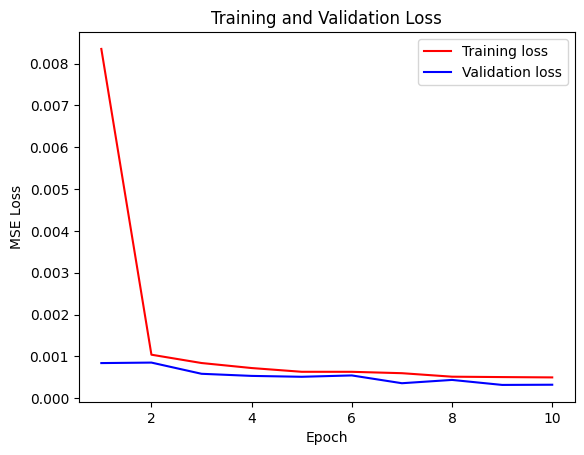

In [8]:
# plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), training_loss, 'r', label='Training loss')
plt.plot(range(1, num_epochs + 1), validation_loss, 'b', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Python(40969) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40971) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(40972) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


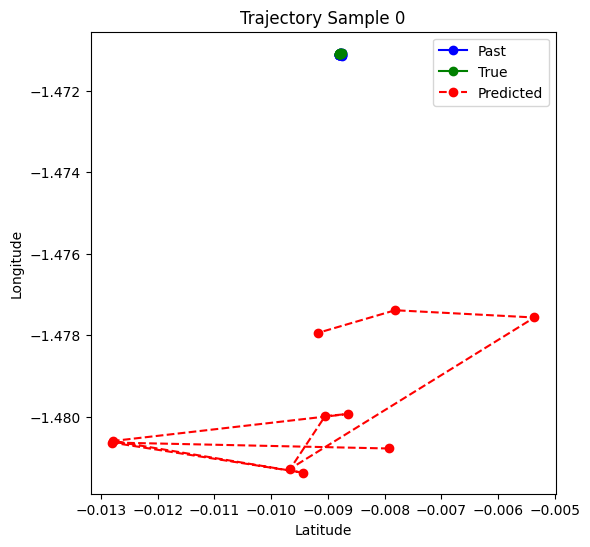

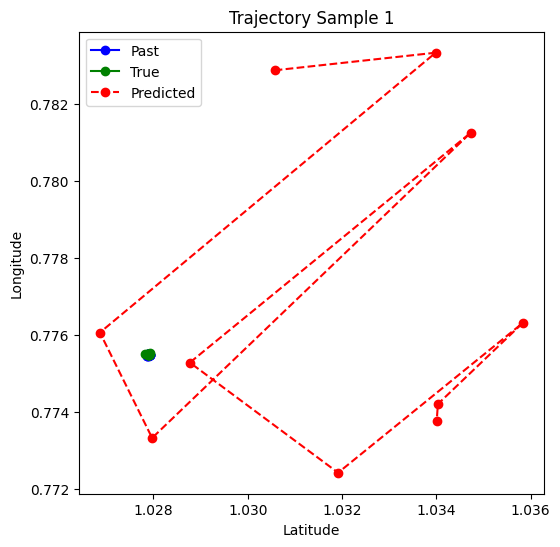

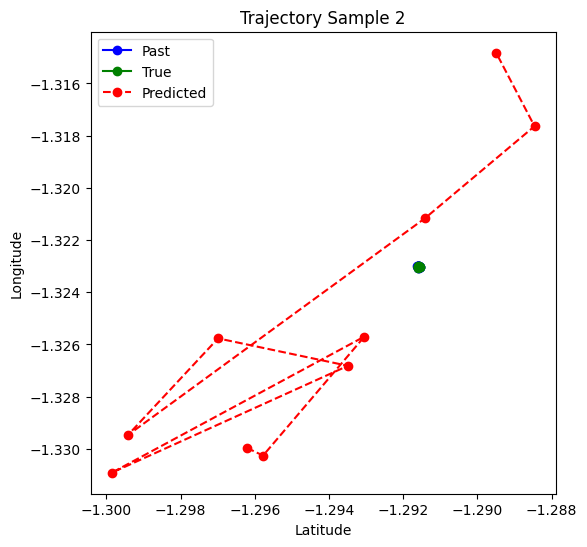

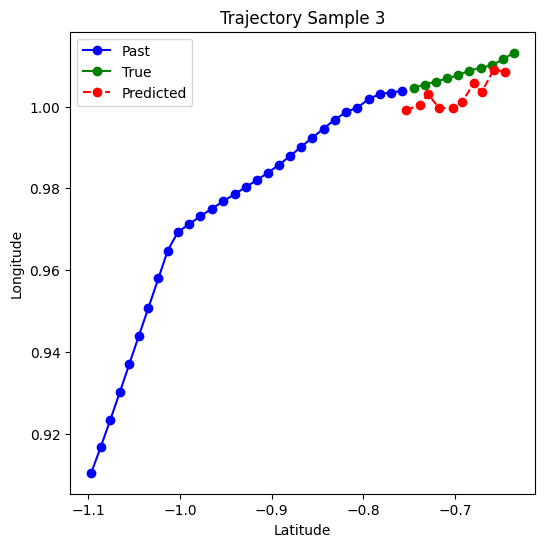

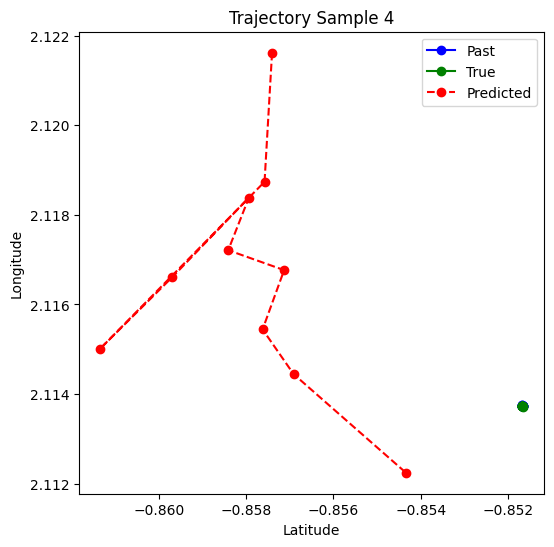

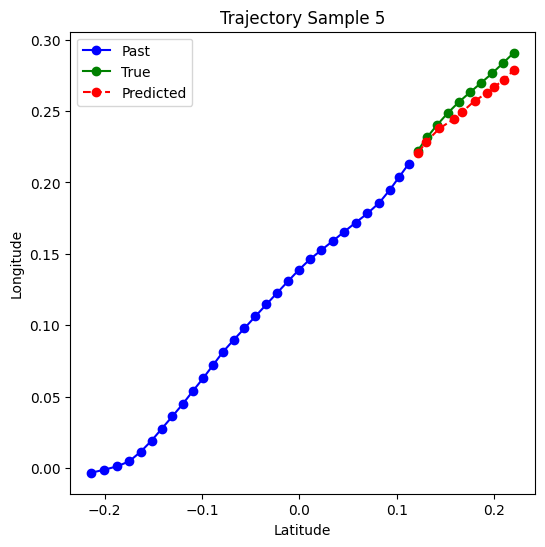

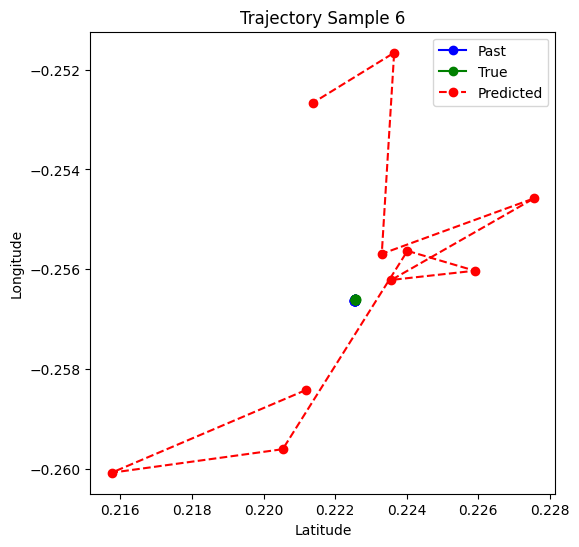

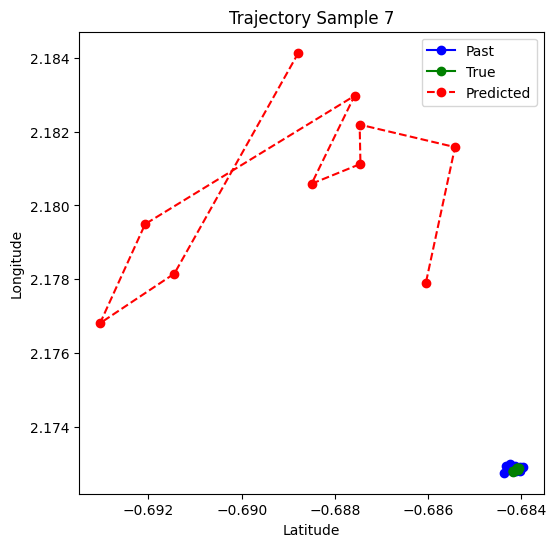

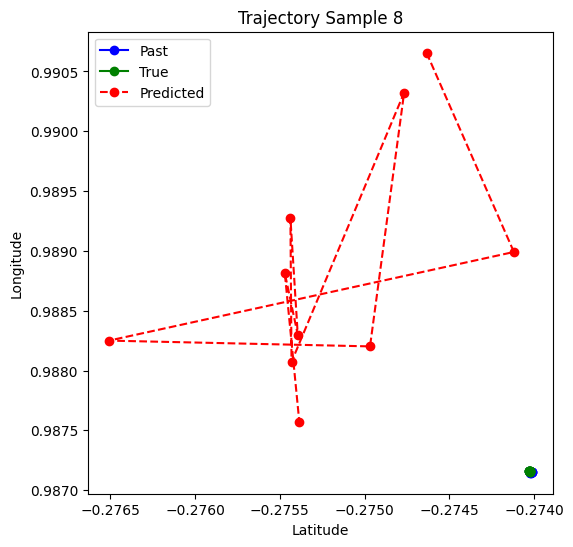

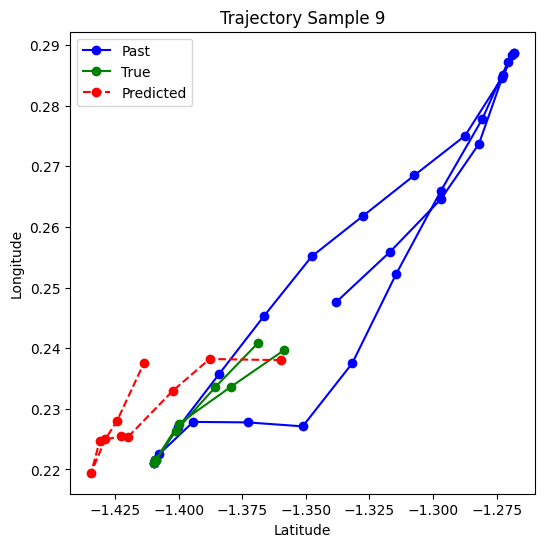

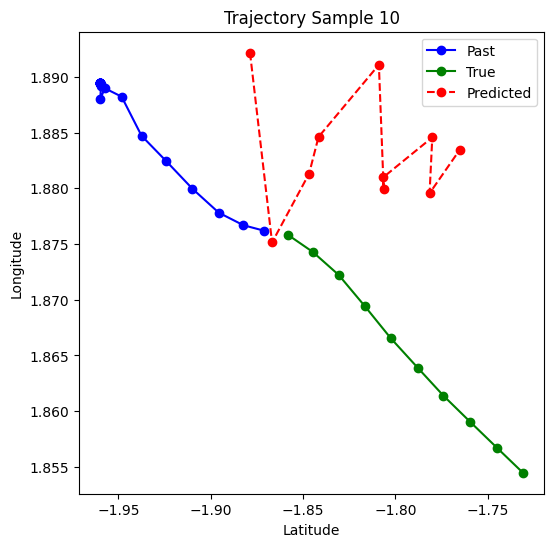

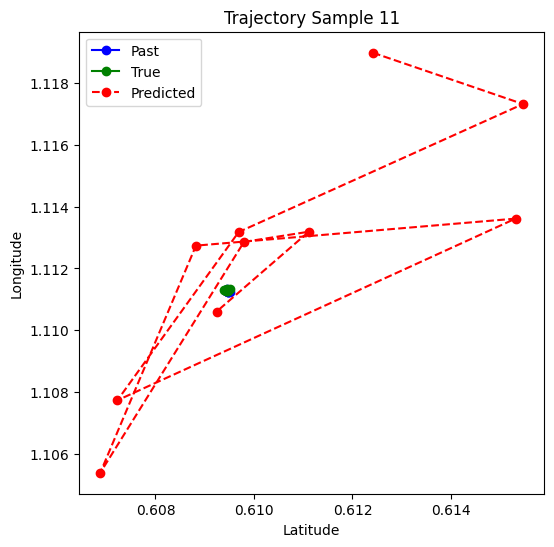

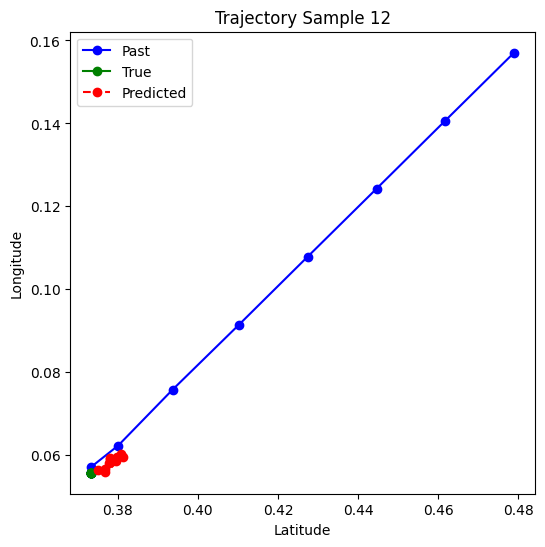

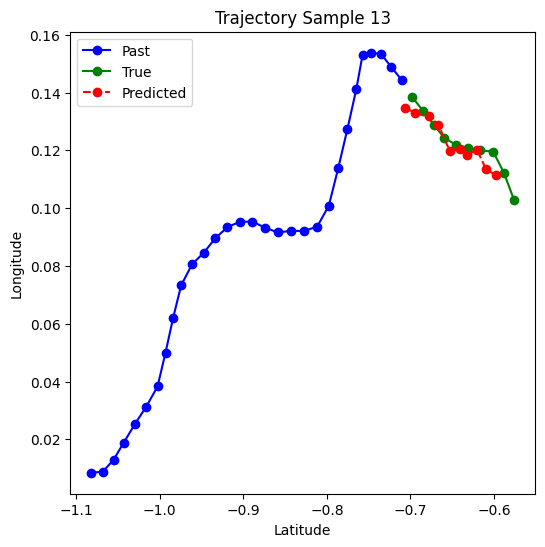

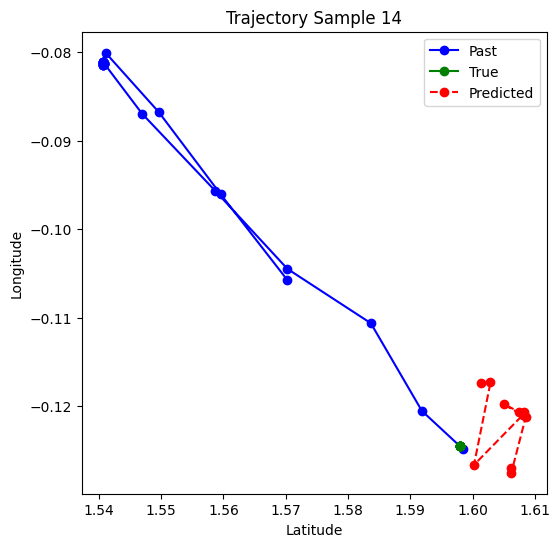

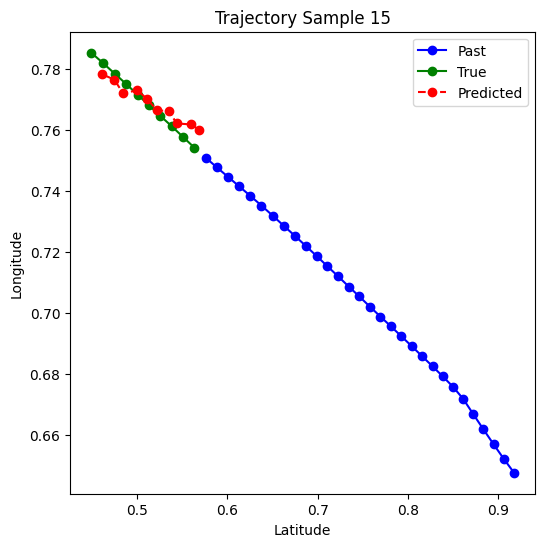

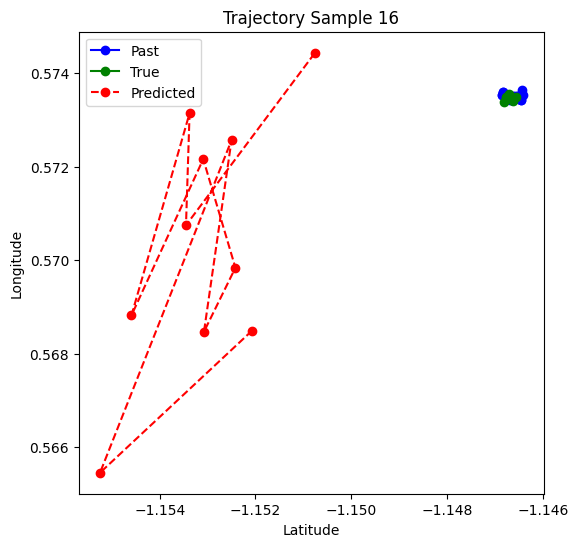

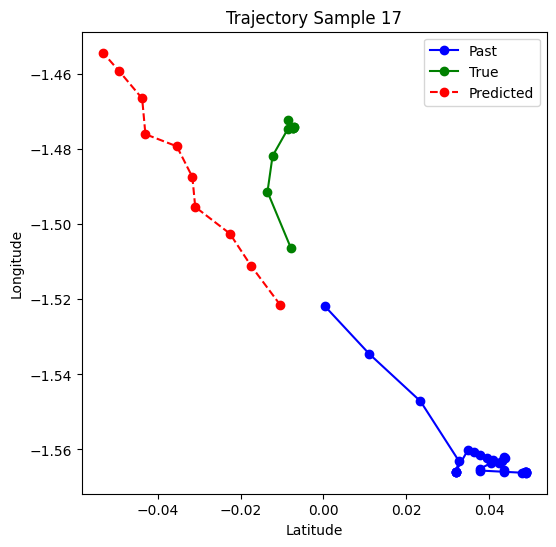

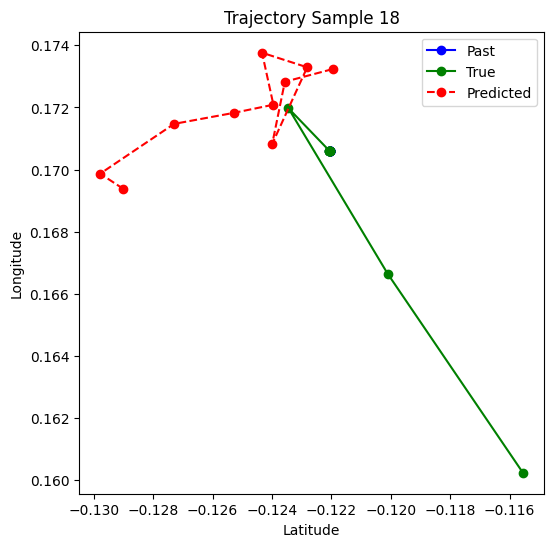

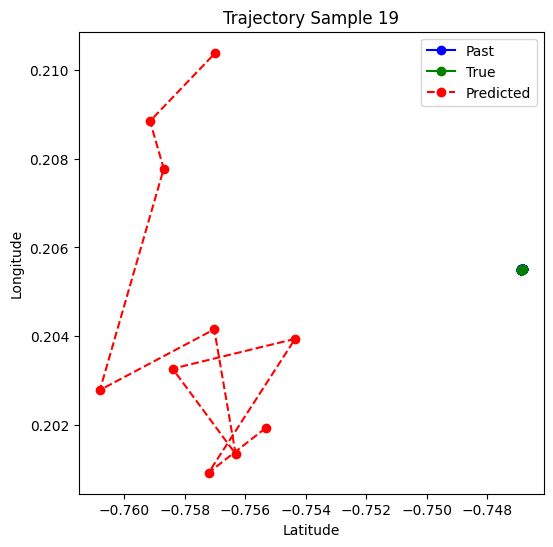

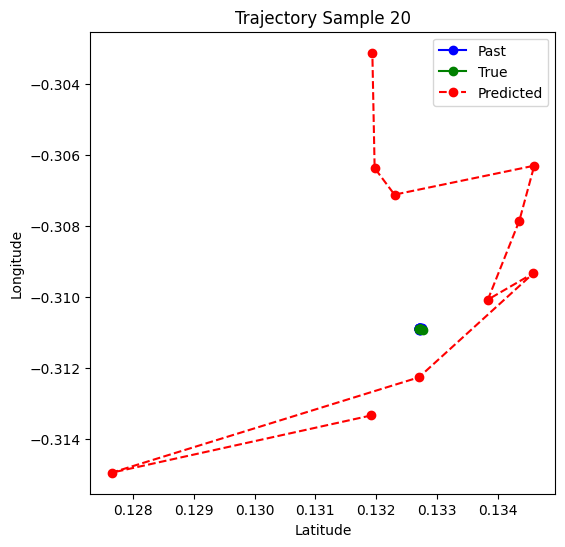

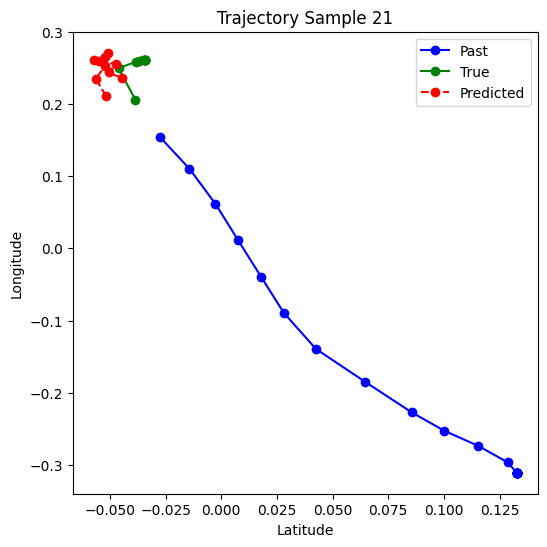

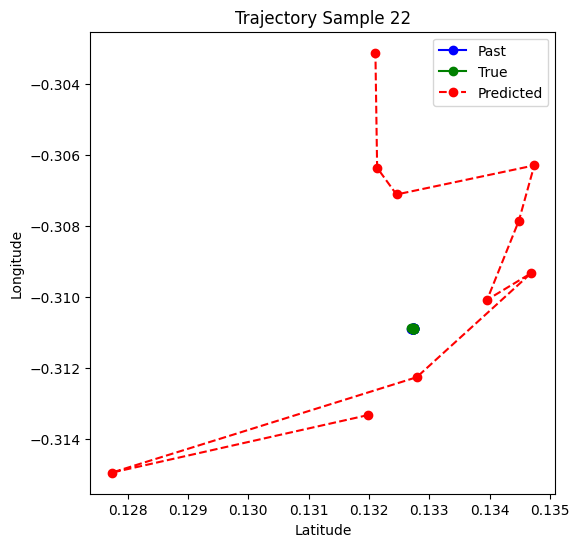

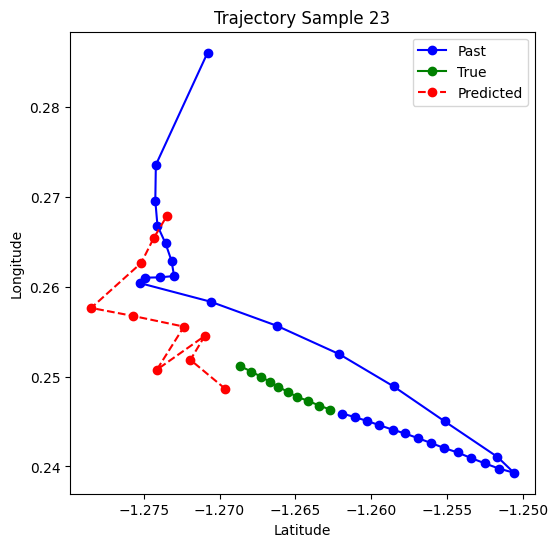

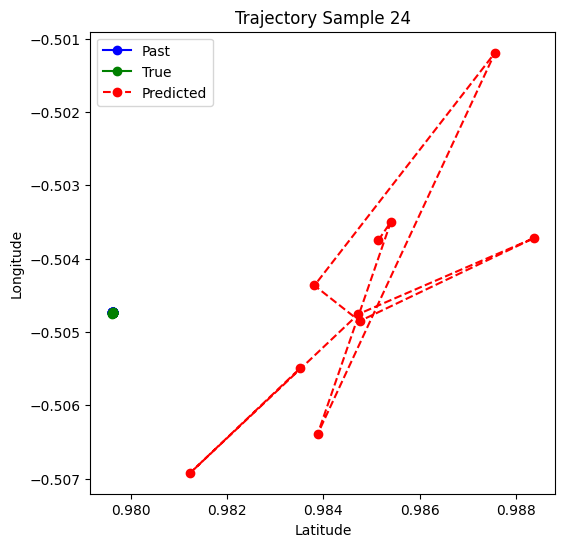

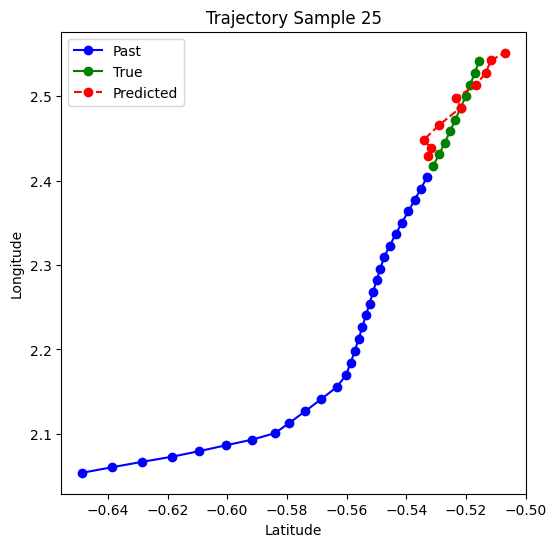

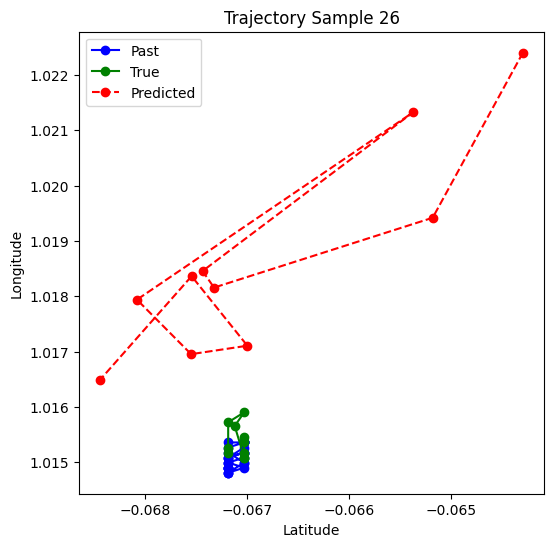

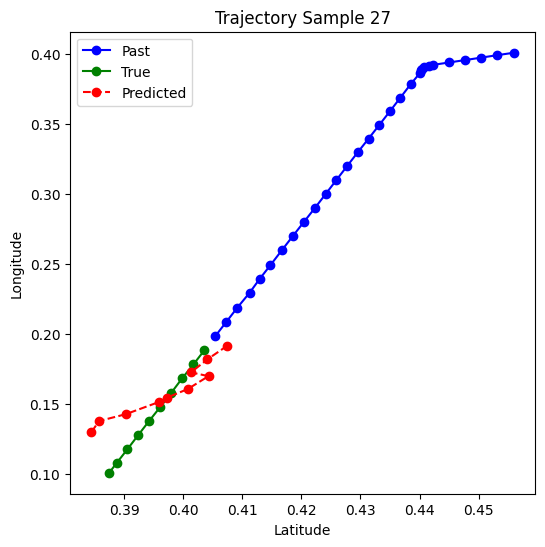

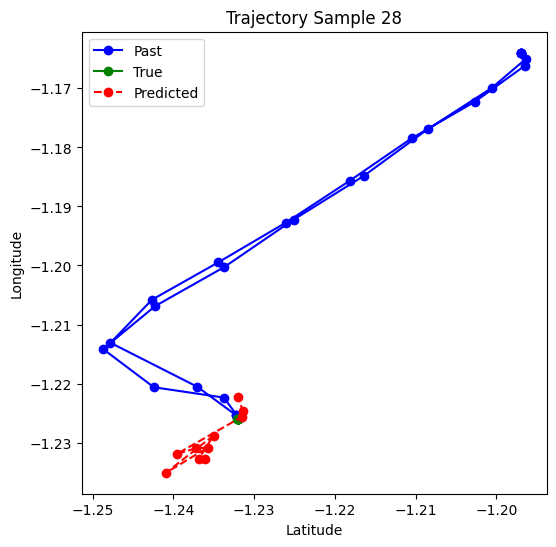

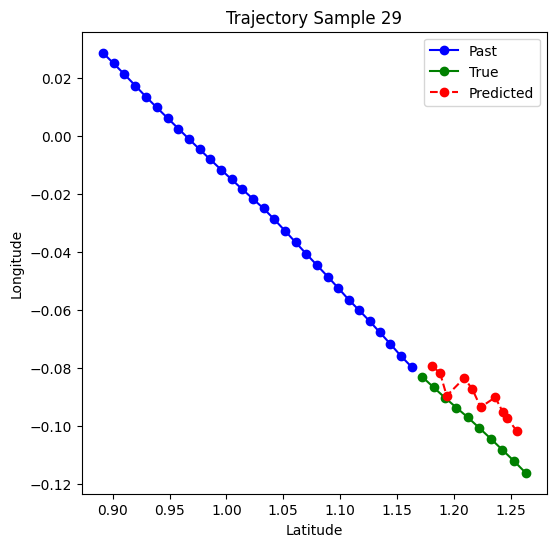

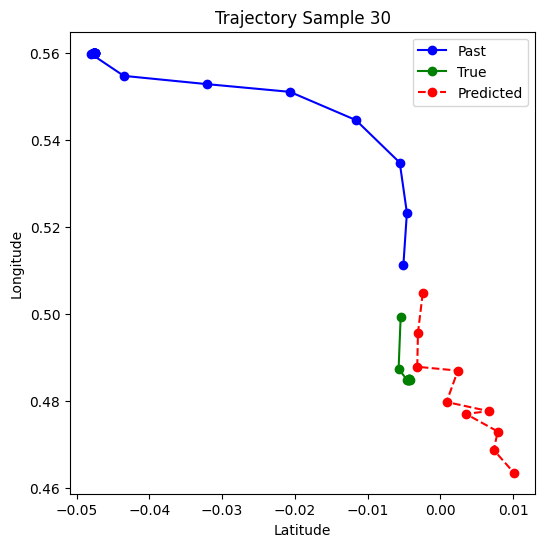

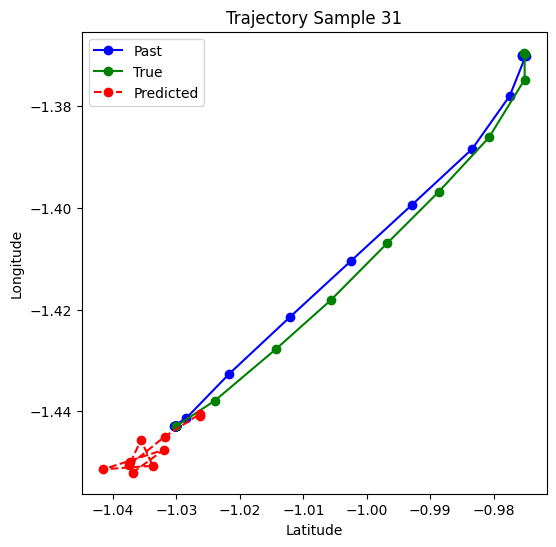

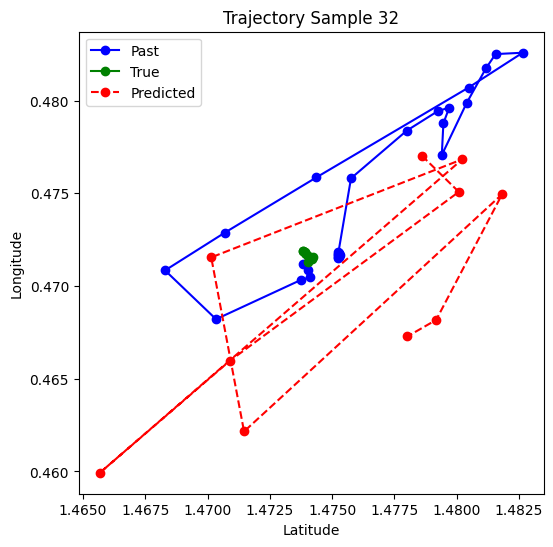

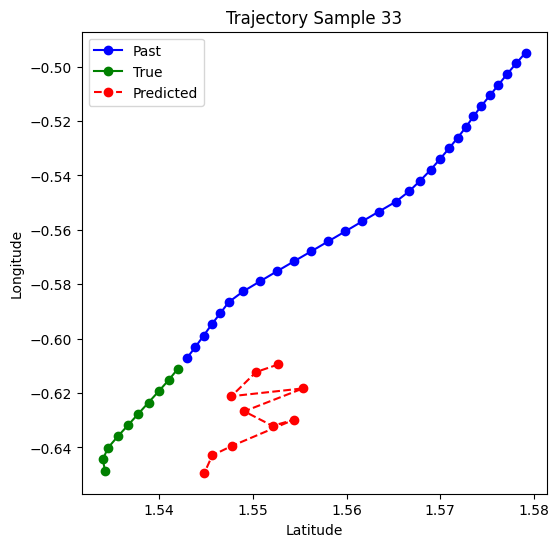

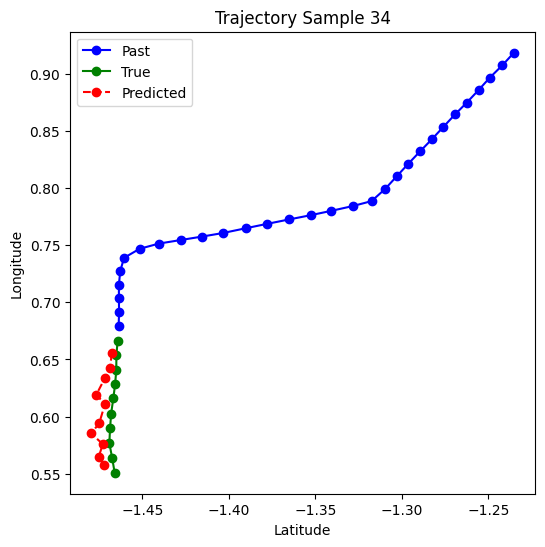

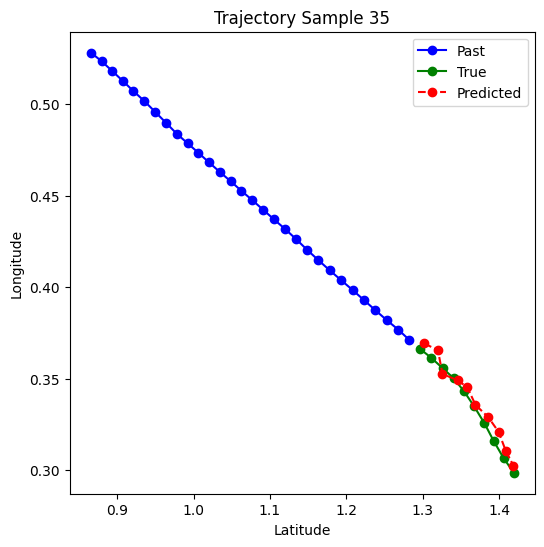

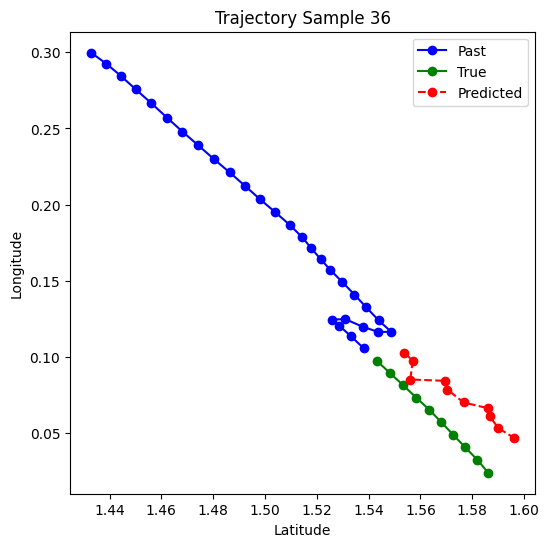

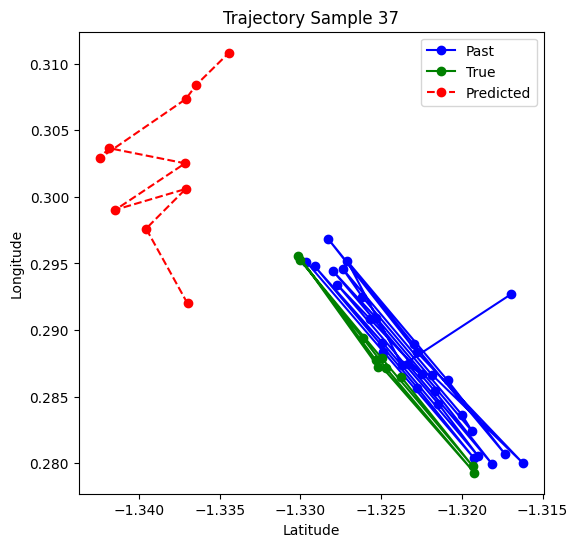

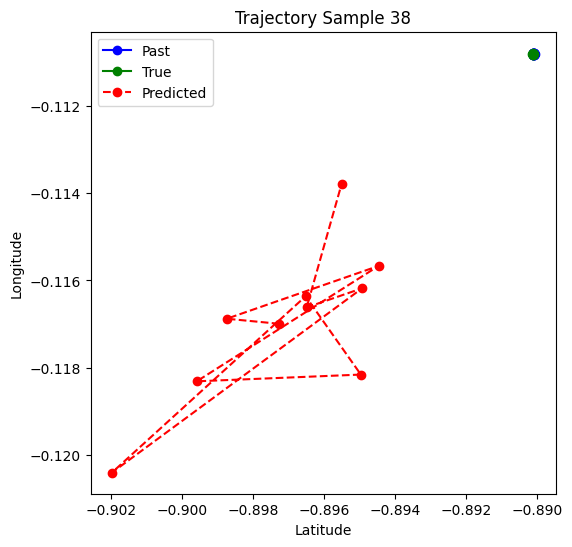

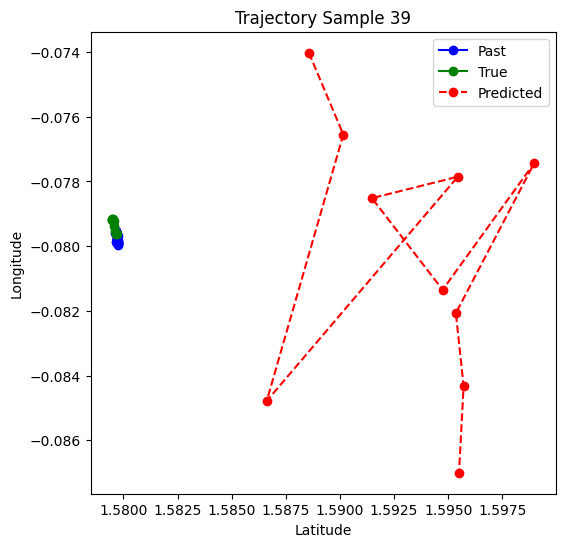

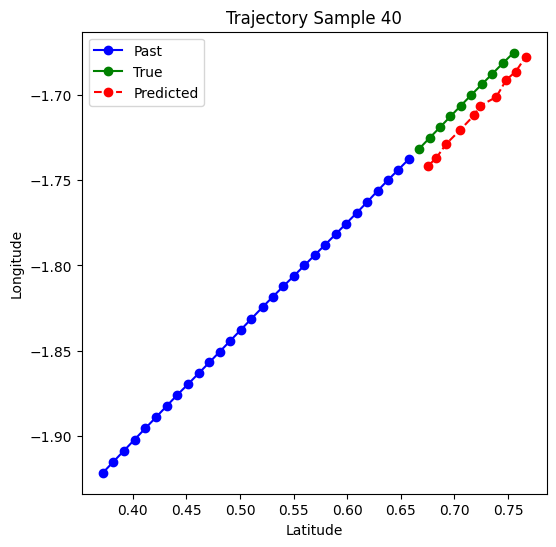

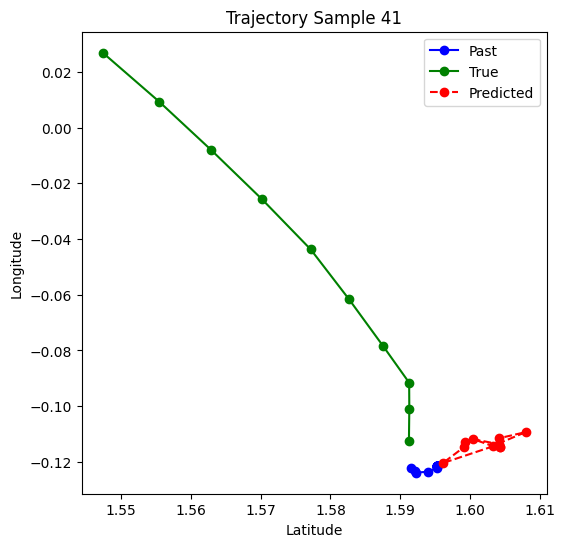

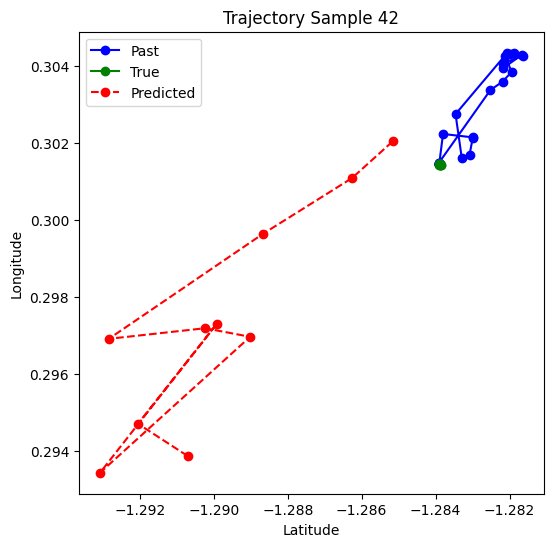

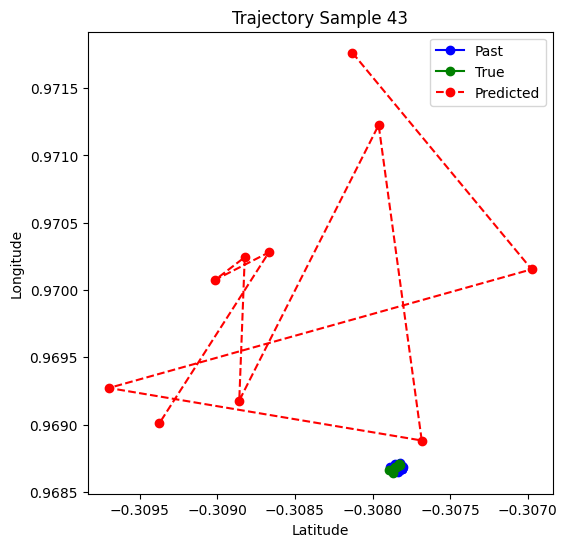

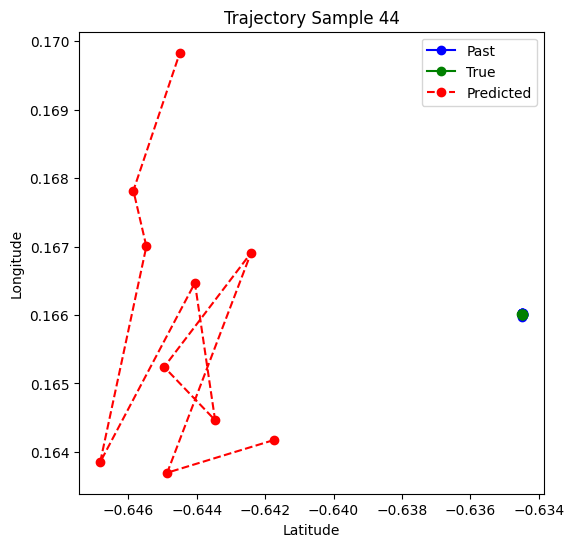

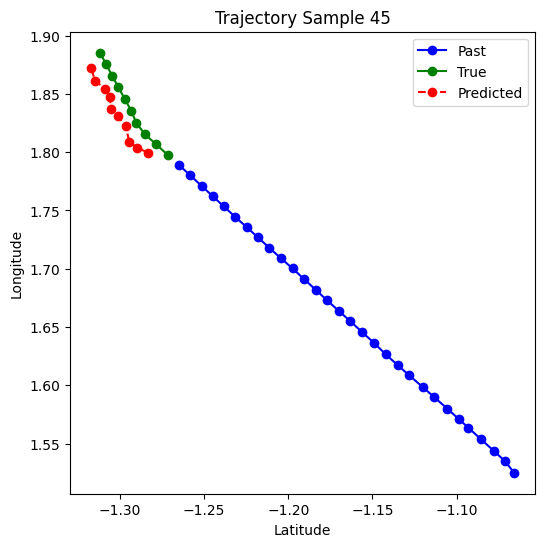

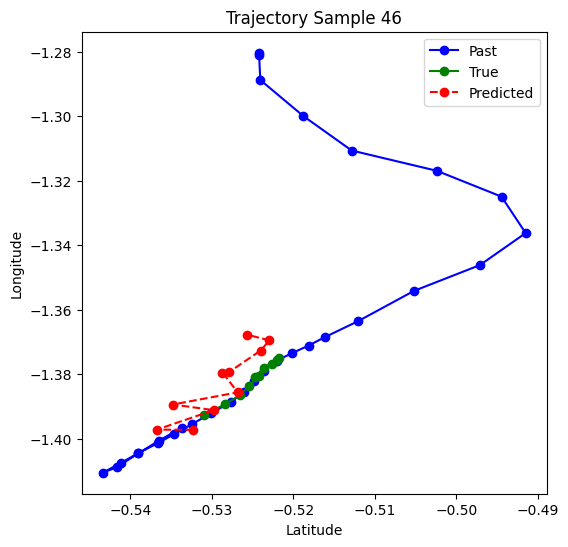

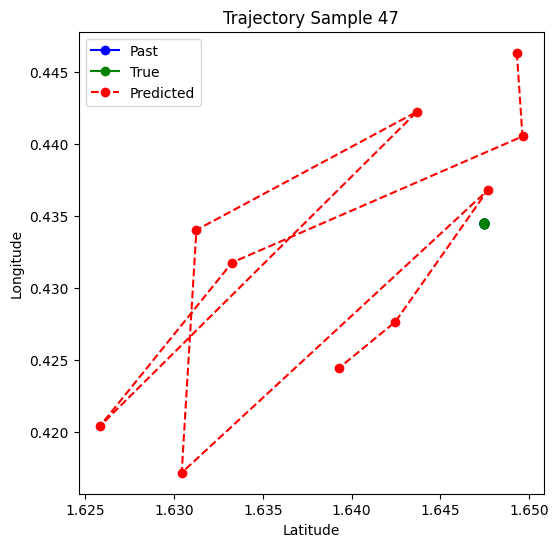

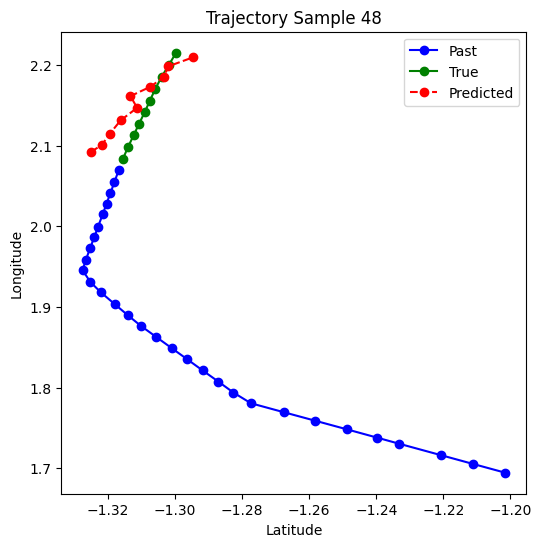

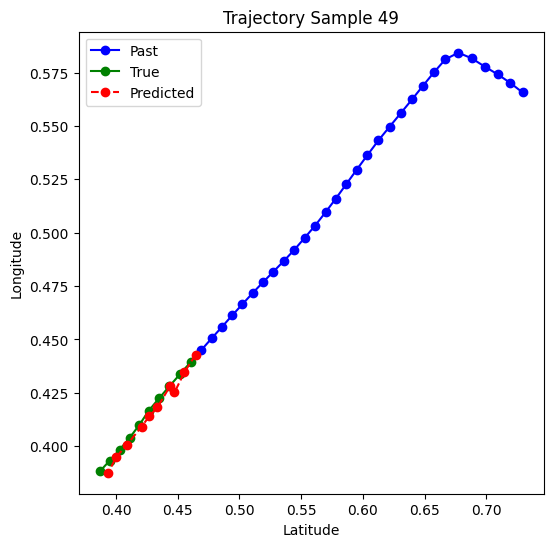

In [9]:
def plot_paths(x_sample, y_true, y_pred, idx):
    # Past  
    x_sample = x_sample.reshape(30, 2) # reshape back
    # True future
    y_true_sample = y_true
    # Predicted future
    y_pred_sample = y_pred

    plt.figure(figsize=(6,6))
    plt.plot(x_sample[:,0], x_sample[:,1], 'bo-', label='Past')         
    plt.plot(y_true_sample[:,0], y_true_sample[:,1], 'go-', label='True')   
    plt.plot(y_pred_sample[:,0], y_pred_sample[:,1], 'ro--', label='Predicted') 
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title(f'Trajectory Sample {idx}')
    plt.legend()
    plt.show()

num_samples_to_plot = 50

# load model
net = model_lstm(hidden_size=hidden_size, num_layers=num_layers).to(device)
net.load_state_dict(torch.load("best_lstm_model.pt"))
net.eval()

# plot
for idx, (x, y) in enumerate(val_loader):
    if idx >= num_samples_to_plot:
        break
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = net(x)
    
    # pick the first element in the batch
    x_np = x[0].cpu().numpy()             # (30,5)
    y_np = y[0].cpu().numpy()             # (10,5)
    y_pred_np = y_pred[0].cpu().numpy().reshape(10, 2)  # reshape flat 50 -> (10,5)

    plot_paths(x_np, y_np, y_pred_np, idx)
